In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
# 步骤
# 1. loads data
# 2. preprocesses data -> dataset
# 3. tools
# 3.1 generate positional embedding
# 3.2 create mask (a. padding, b. decoder)
# 3.3 scaled_dot_product_attention
# 4. build model
# 4.1 MultiHeadAttention
# 4.2 EncoderLayer
# 4.3 DecoderLayer
# 4.4 EncoderModel
# 4.5 DecoderModel
# 4.6 Transformer(将之前的内容综合在一起)
# 5. optimizer & loss
# 6. train_step -> train
# 7. Evaluate & Visualize


# tips:
# 1. 使用矩阵的shape最为线索跟踪整个过程

## 1. 载入数据

In [3]:
# 读取数据
import tensorflow_datasets as tfds

examples, info = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']
print(info)

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=0.0.1,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.
',
    urls=['https://github.com/neulab/word-embeddings-for-nmt'],
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=54781,
    splits={
        'test': 1803,
        'train': 51785,
        'validation': 1193,
    },
    supervised_keys=('pt', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
      booktitle = {HLT-NAACL},
      year    = {2018},
      }""",
    redistribution_info=,
)



In [4]:
for pt, en in train_examples.take(5):
    print(pt.numpy())
    print(en.numpy())
    print()

b'o problema \xc3\xa9 que nunca vivi l\xc3\xa1 um \xc3\xbanico dia .'
b"except , i 've never lived one day of my life there ."

b'os astr\xc3\xb3nomos acreditam que cada estrela da gal\xc3\xa1xia tem um planeta , e especulam que at\xc3\xa9 um quinto deles tem um planeta do tipo da terra que poder\xc3\xa1 ter vida , mas ainda n\xc3\xa3o vimos nenhum deles .'
b"astronomers now believe that every star in the galaxy has a planet , and they speculate that up to one fifth of them have an earth-like planet that might be able to harbor life , but we have n't seen any of them ."

b'agora aqui temos imagens sendo extra\xc3\xaddas em tempo real diretamente do feed ,'
b'now here are live images being pulled straight from the feed .'

b'agora : um , dois , tr\xc3\xaas , vai .'
b'so : one , two , three , go .'

b'eventualmente , vamos ver se teremos todos os sentidos humanos empregues , e se vamos ter meios para viver a hist\xc3\xb3ria qualquer que seja a via escolhida .'
b'eventually , we can see i

## 2. 数据预处理 生成dataset

In [5]:
# 构建Subword词表
en_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus((en.numpy() for pt, en in train_examples), target_vocab_size=2**13)
pt_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus((pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [6]:
sample_string = 'Transformer is awesome.'
tokenized_string = en_tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))
origin_string = en_tokenizer.decode(tokenized_string)
print('Original string is {}'.format(origin_string))

for token in tokenized_string:
    print('{} -> "{}"'.format(token, en_tokenizer.decode([token])))   # ""为了显示空格

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
Original string is Transformer is awesome.
7915 -> "T"
1248 -> "ran"
7946 -> "s"
7194 -> "former "
13 -> "is "
2799 -> "awesome"
7877 -> "."


In [7]:
# 生成dataset
buffer_size = 20000
batch_size = 64
max_length = 40

def encode_to_subword(pt_sentence, en_sentence):
    pt_sequence = [pt_tokenizer.vocab_size] + pt_tokenizer.encode(pt_sentence.numpy()) + [pt_tokenizer.vocab_size + 1]
    en_sequence = [en_tokenizer.vocab_size] + en_tokenizer.encode(en_sentence.numpy()) + [en_tokenizer.vocab_size + 1]
    return pt_sequence, en_sequence

def filter_by_max_length(pt, en):
    return tf.logical_and(tf.size(pt) <= max_length, tf.size(en) <= max_length)

def tf_encode_to_subword(pt_sentence, en_sentence):
    return tf.py_function(encode_to_subword, [pt_sentence, en_sentence], [tf.int64, tf.int64])

train_dataset = train_examples.map(tf_encode_to_subword)
train_dataset = train_dataset.filter(filter_by_max_length)
train_dataset = train_dataset.shuffle(buffer_size).padded_batch(batch_size, padded_shapes=([-1], [-1]))

valid_dataset = val_examples.map(tf_encode_to_subword)
valid_dataset = valid_dataset.filter(filter_by_max_length).padded_batch(batch_size, padded_shapes=([-1], [-1]))

In [8]:
for pt_batch, en_batch in valid_dataset.take(5):
    print(pt_batch.shape, en_batch.shape)

(64, 40) (64, 40)
(64, 38) (64, 40)
(64, 40) (64, 40)
(64, 39) (64, 39)
(64, 37) (64, 38)


## 3. 工具函数

### 3.1 生成位置编码

In [9]:
# PE(pos, 2i) = sin(pos / 10000^(2i/d_model))   # 偶数位
# PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model)) # 奇数位

# pos.shape: (sentence_length, 1)
# i.shape: (1, d_model)
# resunt.shape: (sentence_length, d_model)
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2*(i//2)) / np.float32(d_model))
    return pos * angle_rates

def get_position_embedding(sentence_length, d_model):
    angle_rads = get_angles(np.arange(sentence_length)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    
    # sins.shape: [sentence_length, d_model / 2]
    # cosins.shape: [sentence_length, d_model / 2]
    sins = np.sin(angle_rads[:, 0::2])   # 0::2 获取偶数位的值
    cosins = np.cos(angle_rads[:, 1::2]) # 1::2 获取奇数位的值
    
    # position_embedding.shape: [sentence_length, d_model]
    position_embedding = np.concatenate([sins, cosins], axis=-1)
    # position_embedding.shape: [1, sentence_length, d_model]
    position_embedding = position_embedding[np.newaxis, ...]   # 在最前面添加一个维度
    return tf.cast(position_embedding, dtype=tf.float32)

position_embedding = get_position_embedding(50, 512)
print(position_embedding)

tf.Tensor(
[[[ 0.          0.          0.         ...  1.          1.
    1.        ]
  [ 0.84147096  0.8218562   0.8019618  ...  1.          1.
    1.        ]
  [ 0.9092974   0.9364147   0.95814437 ...  1.          1.
    1.        ]
  ...
  [ 0.12357312  0.97718984 -0.24295525 ...  0.9999863   0.99998724
    0.99998814]
  [-0.76825464  0.7312359   0.63279754 ...  0.9999857   0.9999867
    0.9999876 ]
  [-0.95375264 -0.14402692  0.99899054 ...  0.9999851   0.9999861
    0.9999871 ]]], shape=(1, 50, 512), dtype=float32)


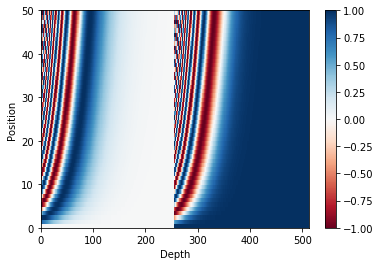

In [10]:
def plot_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding[0], cmap='RdBu')
    plt.xlabel('Depth')
    plt.xlim((0, 512))
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()
    
plot_position_embedding(position_embedding)

### 3.2 生成mask

In [11]:
# 1. padding mask
# 2. decoder mask: look ahead mask

# batch_data.shape: (batch_size, sequence_length)
def create_padding_mask(batch_data):
    padding_mask = tf.cast(tf.math.equal(batch_data, 0), tf.float32)   # 没有取反
    # after expand_dim padding_mask.shape: (batch_size, 1, 1, sequence_length)
    return padding_mask[:, tf.newaxis, tf.newaxis, :]

x = tf.constant([[7, 6 ,0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=208878, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [12]:
def create_look_ahead_mask(size):   # 将矩阵的上三角设为1, 其余的设0
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1 ,0)
    # mask.shape: (sequence_length, sequence_length)
    return mask

create_look_ahead_mask(3)

<tf.Tensor: id=208886, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

### 3.3 缩放点击注意力

In [13]:
def scaled_dot_product_attention(q, k, v, mask):
    # q.shape: (..., seq_len_q, depth)
    # k.shape: (..., seq_len_k, depth)
    # v.shape: (..., seq_len_v, depth)
    # seq_len_k == seq_len_v
    # mask.shape: (..., seq_len_q, seq_len_k)
    
    # matmul_qk.shape: (..., seq_len_q, seq_len_k)
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # 只对后两位进行矩阵乘法
    dk = tf.cast(tf.shape(k)[-1], tf.float32)   # dimension of k
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        # 使得在softmax的之后要被mask的值趋近于0
        scaled_attention_logits += (mask * -1e9)
    # attention_weights.shape: (..., seq_len_q, seq_len_k)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # 在seq_len_k的维度上进行softmax获取权重，以便和v相乘
    
    # output.shape: (..., seq_len_q, depth_v)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

def print_scaled_dot_product_attention(q, k, v):
    temp_out, temp_att = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are: ', temp_att)
    print('Output is: ', temp_out)

In [14]:
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32) # (4, 3)
temp_v = tf.constant([[1, 0],
                      [10, 0], 
                      [100, 5],
                      [1000, 6]], dtype=tf.float32) # (4, 2)
temp_q1 = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_scaled_dot_product_attention(temp_q1, temp_k, temp_v)

Attention weights are:  tf.Tensor([[8.433274e-26 1.000000e+00 8.433274e-26 8.433274e-26]], shape=(1, 4), dtype=float32)
Output is:  tf.Tensor([[1.000000e+01 9.276601e-25]], shape=(1, 2), dtype=float32)


In [15]:
temp_q2 = tf.constant([[0, 0, 10]], dtype=tf.float32) # (1, 3)
print_scaled_dot_product_attention(temp_q2, temp_k, temp_v)

Attention weights are:  tf.Tensor([[4.216637e-26 4.216637e-26 5.000000e-01 5.000000e-01]], shape=(1, 4), dtype=float32)
Output is:  tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [16]:
temp_q3 = tf.constant([[10, 10, 0]], dtype=tf.float32) # (1, 3)
print_scaled_dot_product_attention(temp_q3, temp_k, temp_v)

Attention weights are:  tf.Tensor([[5.000000e-01 5.000000e-01 4.216637e-26 4.216637e-26]], shape=(1, 4), dtype=float32)
Output is:  tf.Tensor([[5.5000000e+00 4.6383005e-25]], shape=(1, 2), dtype=float32)


In [17]:
temp_q4 = tf.constant([[0, 10, 0],
                       [0, 0, 10],
                       [10, 10, 0]], dtype=tf.float32)
print_scaled_dot_product_attention(temp_q4, temp_k, temp_v)

Attention weights are:  tf.Tensor(
[[8.433274e-26 1.000000e+00 8.433274e-26 8.433274e-26]
 [4.216637e-26 4.216637e-26 5.000000e-01 5.000000e-01]
 [5.000000e-01 5.000000e-01 4.216637e-26 4.216637e-26]], shape=(3, 4), dtype=float32)
Output is:  tf.Tensor(
[[1.0000000e+01 9.2766009e-25]
 [5.5000000e+02 5.5000000e+00]
 [5.5000000e+00 4.6383005e-25]], shape=(3, 2), dtype=float32)


## 4. 构建模型

### 4.1 多头注意力

In [18]:
class MultiHeadAttention(keras.layers.Layer):
    '''
    x -> Wq0 -> q0
    x -> Wk0 -> k0
    x -> Wv0 -> v0
    在这里实现的时候将x取的不一定是一样的值
    q -> Wq0 -> q0
    k -> Wk0 -> k0
    v -> Wv0 -> v0
    在实现中先乘一个大矩阵，然后拆分成q0, q1, ..., k0, k1, ... 
    q -> Wq -> Q -> split -> q0, q1, ...
    '''
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        assert self.d_model % self.num_heads == 0
        self.depth = self.d_model // self.num_heads
        self.WQ = keras.layers.Dense(self.d_model)  # q, k, v乘的大矩阵
        self.WK = keras.layers.Dense(self.d_model)
        self.WV = keras.layers.Dense(self.d_model)
        self.dense = keras.layers.Dense(self.d_model)   # 最后的全连接层   
    
    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]
        
        # q.shape(batch_size, seq_len_q, d_model)
        q = self.WQ(q)
        # k.shape(batch_size, seq_len_k, d_model)
        k = self.WK(k)
        # v.shape(batch_size, seq_len_v, d_model)   这里要求seq_len_k == seq_len_v
        v = self.WV(v)
        
        # q.shape: (batch_size, num_heads, seq_len_q, depth)
        q = self.split_heads(q, batch_size)
        # k.shape: (batch_size, num_heads, seq_len_k, depth)
        k = self.split_heads(k, batch_size)
        # v.shape: (batch_size, num_heads, seq_len_v, depth)
        v = self.split_heads(v, batch_size)
        
        # scaled_attention_outputs.shape: (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape: (batch_size, num_heads, seq_len_q, sen_len_k)
        scaled_attention_outputs, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        # scaled_attention_outputs.shape: (batch_size, seq_len_q, num_heads, depth)
        scaled_attention_outputs = tf.transpose(scaled_attention_outputs, perm=[0, 2, 1, 3])
        # concat_attention.shape: (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention_outputs, (batch_size, -1, self.d_model))
        
        # 经过最后的全连接层
        # output.shape: (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)
        
        return output, attention_weights
                                      
    def split_heads(self, x, batch_size):
        # input x.shape: (batch_size, seq_len, d_model)
        # d_model = num_heads * depth
        # x -> (batch_size, num_heads, seq_len, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])   # 维度重排列
    
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 256))  # (batch_size, seq_len_q, dim)
output, attn = temp_mha(y, y, y, mask=None)   # self attention
print(output.shape, attn.shape)


(1, 60, 512) (1, 8, 60, 60)


### 4.2 EncoderLayer

In [19]:
def feed_forward_network(d_model, dff):
    # dff: dim off feed_fordward_network
    return keras.Sequential([
        keras.layers.Dense(dff, activation='relu'),
        keras.layers.Dense(d_model)
    ])

sample_ffn = feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [20]:
class EncoderLayer(keras.layers.Layer):
    '''
        理论:
        x -> self attention -> add & normalize -> feed_forword -> add & normalize
        实现:
        x -> self attention -> add & normalize & dropout -> feed_forword -> add & normalize & dropout
    '''
    def __init__(self, d_model, num_heads, dff, rate=0.1):  # the parameter 'rate' is for dropout
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward_network(d_model, dff)
        self.layer_normal1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_normal2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        
    def call(self, x, training, encoder_padding_mask):
        # x.shape: (batch_size, seq_len, dim)  # 这里因为要做残差连接，dim == d_model
        # attn_output.shape: (batch_size, seq_len, d_model)
        attn_outputs, _ = self.mha(x, x, x, encoder_padding_mask)   # 做self attention
        attn_outputs = self.dropout1(attn_outputs, training=training)
        # out1.shape: (batch_size, seq_len, d_model)
        out1 = self.layer_normal1(x + attn_outputs)
        
        # ffn_output.shape: (batch_size, seq_len, d_model)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # out2.shape: (batch_size, seq_len, d_model)
        out2 = self.layer_normal2(out1 + ffn_output)
        
        return out2
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_input= tf.random.uniform((64, 50, 512))
sample_output = sample_encoder_layer(sample_input, False, None)
print(sample_output.shape)

(64, 50, 512)


### 4.3 DecoderLayer

In [21]:
class DecoderLayer(keras.layers.Layer):
    '''
        x -> self attention -> add & normalize & dropout -> encoder_decoder_attention -> add & normalize & dropout
        -> feed fordward network -> add & normalize & dropout
    '''
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = feed_forward_network(d_model, dff)
        
        self.layer_norm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
        
    def call(self, x, encoding_outputs, training, decoder_mask, encoder_decoder_padding_mask):
        # decoder_mask: 由look_ahead_mask和decoder_padding合并而来
        # x.shape: (batch_size, target_seq_len, d_model)
        # encoding_outputs.shape: (batch_size, input_seq_len, d_model)
        
        # attn1, out1.shape: (batch_size, target_seq_len, d_model)
        attn1, attn_weights1 = self.mha1(x, x, x, decoder_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layer_norm1(attn1 + x)
        
        # attn2, out2.shape: (batch_size, target_seq_len, d_model)
        attn2, attn_weights2 = self.mha2(out1, encoding_outputs, encoding_outputs, encoder_decoder_padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layer_norm2(attn2 + out1)
        
        # ffn_output, out3.shape: (batch_size, target_seq_len, d_model)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layer_norm3(ffn_output + out2)
        
        return out3, attn_weights1, attn_weights2

sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_input = tf.random.uniform((64, 60, 512))
sample_decoder_output, sample_decoder_attn_weights1, sample_decoder_attn_weights2 = sample_decoder_layer(sample_decoder_input, sample_output, False, None, None)
print(sample_decoder_output.shape)
print(sample_decoder_attn_weights1.shape)
print(sample_decoder_attn_weights2.shape)

(64, 60, 512)
(64, 8, 60, 60)
(64, 8, 60, 50)


### 4.4 EncoderModel

In [22]:
class EncoderModel(keras.layers.Layer):
    def __init__(self, num_layers, input_vocab_size, max_length, d_model, num_heads, dff, rate=0.1):
        super(EncoderModel, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.max_length = max_length
        
        self.embedding = keras.layers.Embedding(input_vocab_size, self.d_model)
        # position_embedding.shape: (1, max_length, d_model)
        self.position_embedding = get_position_embedding(max_length, self.d_model)
        
        self.encoder_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(self.num_layers)]
        
        self.dropout = keras.layers.Dropout(rate)   # 在这里x的embedding加上位置编码后先通过一个dropout层
        
    def call(self, x, training, encoder_padding_mask):
        # x.shape: (batch_size, input_seq_len)
        input_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(input_seq_len, self.max_length, 
                                       'input_seq_len should be less or equal to self.max_length')
        
        # x.shape: (batch_size, input_seq_len, d_model)
        x = self.embedding(x)
        # x经过embedding后的初始值是(0, 1)的均匀分布，因此进行缩放变成(0, d_model),使得在机上位置编码后x本身起的作用比较大
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[:, :input_seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, training, encoder_padding_mask)
        
        # x.shape: (batch_size, input_seq_len, d_model)
        return x
    
sample_encoder_model = EncoderModel(2, 8500, max_length, 512, 8, 2048)
sample_encoder_model_input = tf.random.uniform((64, 37))
sample_encoder_model_output = sample_encoder_model(sample_encoder_model_input, False, None)

print(sample_encoder_model_output.shape) 

(64, 37, 512)


### 4.5 DecoderModel

In [23]:
class DecoderModel(keras.layers.Layer):
    def __init__(self, num_layers, target_vocab_size, max_length, d_model, num_heads, dff, rate=0.1):
        super(DecoderModel, self).__init__()
        self.num_layers = num_layers
        self.max_length = max_length
        self.d_model = d_model
        
        self.embedding = keras.layers.Embedding(target_vocab_size, self.d_model)
        self.position_embedding = get_position_embedding(self.max_length, self.d_model)
        
        self.dropout = keras.layers.Dropout(rate)   # 在这里x的embedding加上位置编码后先通过一个dropout层
        
        self.decoder_layers = [DecoderLayer(self.d_model, num_heads, dff, rate) for _ in range(self.num_layers)]
        
    def call(self, x, encoding_outputs, training, decoder_mask, encoder_decoder_padding_mask):
        # x.shape: (batch_size, output_seq_len)
        output_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(output_seq_len, self.max_length, 'output_seq_len should be less or equal to self.max_length')
        
        attention_weights = {}
        
        # x.shape: (batch_size, output_seq_len, d_model)
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[:, : output_seq_len, :]
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, attn1, attn2 = self.decoder_layers[i](x, encoding_outputs, training, decoder_mask, encoder_decoder_padding_mask)
            attention_weights['decoder_layer{}_att1'.format(i+1)] = attn1
            attention_weights['decoder_layer{}_att2'.format(i+1)] = attn2
            
        # x.shape: (batch_size, output_seq_len, d_model)
        return x, attention_weights
    
sample_decoder_model = DecoderModel(2, 8000, max_length, 512, 8, 2048)
sample_decoder_model_input = tf.random.uniform((64, 35))
sample_decoder_model_output, sample_decoder_model_attn = sample_decoder_model(sample_decoder_model_input, sample_encoder_model_output, False, decoder_mask=None, encoder_decoder_padding_mask=None)
print(sample_decoder_model_output.shape)
for key in sample_decoder_model_attn:
    print(sample_decoder_model_attn[key].shape)

(64, 35, 512)
(64, 8, 35, 35)
(64, 8, 35, 37)
(64, 8, 35, 35)
(64, 8, 35, 37)


### 4.6 Transformer

In [24]:
class Transformer(keras.Model):
    def __init__(self, num_layers, input_vocab_size, target_vocab_size, max_length, 
                d_model, num_heads, dff, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder_model = EncoderModel(num_layers, input_vocab_size, max_length, d_model, num_heads, dff, rate)
        self.decoder_model = DecoderModel(num_layers, target_vocab_size, max_length, d_model, num_heads, dff, rate)
        
        self.final_layer = keras.layers.Dense(target_vocab_size)
        
    def call(self, input, target, training, encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask):
        # encodign_output.shape: (batch_size, input_seq_len, d_model)
        encoding_outputs = self.encoder_model(input, training, encoder_padding_mask)
        
        # decoding_outputs.shape: (batch_size, output_seq_len, d_model)
        decoding_outputs, attention_weights = self.decoder_model(target, encoding_outputs, training, decoder_mask, encoder_decoder_padding_mask)
        
        # predictions.shape: (batch_size, output_seq_len, target_vocab_size)
        predictions = self.final_layer(decoding_outputs)
        
        return predictions, attention_weights
    
sample_transformer = Transformer(2, 8500, 8000, max_length, 512, 8, 2048)
temp_input = tf.random.uniform((64, 26))
temp_target = tf.random.uniform((64, 31))

predictions, attention_weights = sample_transformer(temp_input, temp_target, training=False, encoder_padding_mask=None, decoder_mask=None, encoder_decoder_padding_mask=None)
print(predictions.shape)
for key in attention_weights:
    print(attention_weights[key].shape)

(64, 31, 8000)
(64, 8, 31, 31)
(64, 8, 31, 26)
(64, 8, 31, 31)
(64, 8, 31, 26)


In [25]:
# steps for training
# 1. initializes model
# 2. define loss, optimizer: learning rate schedule
# 3. train_step
# 4. train process

In [26]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = pt_tokenizer.vocab_size + 2
target_vocab_size = en_tokenizer.vocab_size + 2
dropout_rate = 0.1

transformer = Transformer(num_layers, input_vocab_size, target_vocab_size, max_length, d_model, num_heads, dff, dropout_rate)

## 5. optimizer & loss

In [27]:
# 自定义学习率
# lr = (d_model ** -0.5) * min(step_num ** -0.5, step_num * warm_up_steps ** -1.5)
class CustomizedSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomizedSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** (-1.5))
        arg3 = tf.math.rsqrt(self.d_model)
        
        return arg3 * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomizedSchedule(d_model)
optimizer = keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

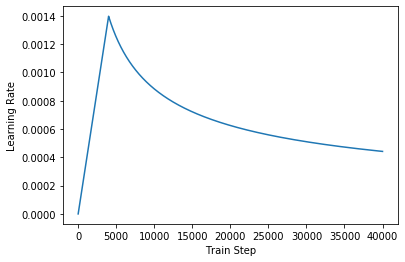

In [28]:
temp_learning_rate = CustomizedSchedule(d_model)
plt.plot(temp_learning_rate(tf.range(40000, dtype=tf.float32)))

plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [29]:
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [30]:
def create_masks(input, target):
    '''
        Encoder: encoder_padding_mask
        Decoder: look_ahead_mask, encoder_decoder_padding_mask, decoder_padding_mask
    '''
    encoder_padding_mask = create_padding_mask(input)
    encoder_decoder_padding_mask = create_padding_mask(input)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(target)[1])
    decoder_padding_mask = create_padding_mask(target)
    # 由于look_ahead_mask和decoder_padding_mask作用在同一个self attention所以将他们进行合并
    decoder_mask = tf.maximum(look_ahead_mask, decoder_padding_mask)
    
    return encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask

In [31]:
temp_inp, temp_tar = iter(train_dataset.take(1)).next()
print(temp_inp.shape)
print(temp_tar.shape)
create_masks(temp_inp, temp_tar)

(64, 40)
(64, 40)


(<tf.Tensor: id=306160, shape=(64, 1, 1, 40), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)>,
 <tf.Tensor: id=306192, shape=(64, 1, 40, 40), dtype=float32, numpy=
 array([[[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1

In [32]:
train_loss = keras.metrics.Mean(name='train_loss')
train_accuracy = keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

@tf.function
def train_step(input, target):
    target_input = target[:, :-1]
    target_real = target[:, 1:]
    
    encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask = create_masks(input, target_input)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(input, target_input, True, encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask)
        loss = loss_function(target_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(target_real, predictions)
    
epochs = 20
for epoch in range(epochs):
    start_time = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (input, target)) in enumerate(train_dataset):
        train_step(input, target)
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch+1, batch, train_loss.result(), train_accuracy.result()))
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch+1, train_loss.result(), train_accuracy.result()))
    print('Time take for this epoch: {} secs'.format(time.time()-start_time))

Epoch 1 Batch 0 Loss 3.9490 Accuracy 0.0000


Epoch 1 Batch 100 Loss 4.2027 Accuracy 0.0156
Epoch 1 Batch 200 Loss 4.0727 Accuracy 0.0213
Epoch 1 Batch 300 Loss 3.9203 Accuracy 0.0255
Epoch 1 Batch 400 Loss 3.7439 Accuracy 0.0336
Epoch 1 Batch 500 Loss 3.5876 Accuracy 0.0397
Epoch 1 Batch 600 Loss 3.4567 Accuracy 0.0468
Epoch 1 Batch 700 Loss 3.3506 Accuracy 0.0537
Epoch 1 Loss 3.3486 Accuracy 0.0538
Time take for this epoch: 757.6038157939911 secs
Epoch 2 Batch 0 Loss 2.6468 Accuracy 0.0962
Epoch 2 Batch 100 Loss 2.5337 Accuracy 0.1065
Epoch 2 Batch 200 Loss 2.4941 Accuracy 0.1101
Epoch 2 Batch 300 Loss 2.4685 Accuracy 0.1142
Epoch 2 Batch 400 Loss 2.4335 Accuracy 0.1174
Epoch 2 Batch 500 Loss 2.4072 Accuracy 0.1206
Epoch 2 Batch 600 Loss 2.3838 Accuracy 0.1234
Epoch 2 Batch 700 Loss 2.3611 Accuracy 0.1257
Epoch 2 Loss 2.3610 Accuracy 0.1258
Time take for this epoch: 98.62832117080688 secs
Epoch 3 Batch 0 Loss 2.1339 Accuracy 0.1438
Epoch 3 Batch 100 Loss 2.1917 Accuracy 0.1442
Epoch 3 Batch 200 Loss 2.1618 Accuracy 0.1449
Epoch 

Epoch 19 Batch 100 Loss 0.5284 Accuracy 0.3465
Epoch 19 Batch 200 Loss 0.5378 Accuracy 0.3453
Epoch 19 Batch 300 Loss 0.5457 Accuracy 0.3443
Epoch 19 Batch 400 Loss 0.5507 Accuracy 0.3437
Epoch 19 Batch 500 Loss 0.5571 Accuracy 0.3432
Epoch 19 Batch 600 Loss 0.5621 Accuracy 0.3419
Epoch 19 Batch 700 Loss 0.5670 Accuracy 0.3412
Epoch 19 Loss 0.5672 Accuracy 0.3412
Time take for this epoch: 70.67188167572021 secs
Epoch 20 Batch 0 Loss 0.4471 Accuracy 0.3425
Epoch 20 Batch 100 Loss 0.5076 Accuracy 0.3493
Epoch 20 Batch 200 Loss 0.5193 Accuracy 0.3497
Epoch 20 Batch 300 Loss 0.5231 Accuracy 0.3491
Epoch 20 Batch 400 Loss 0.5292 Accuracy 0.3478
Epoch 20 Batch 500 Loss 0.5358 Accuracy 0.3469
Epoch 20 Batch 600 Loss 0.5407 Accuracy 0.3460
Epoch 20 Batch 700 Loss 0.5450 Accuracy 0.3449
Epoch 20 Loss 0.5456 Accuracy 0.3449
Time take for this epoch: 66.33680605888367 secs


In [33]:
transformer.save('./transformer_saved_model')

TypeError: call() missing 4 required positional arguments: 'target', 'encoder_padding_mask', 'decoder_mask', and 'encoder_decoder_padding_mask'

In [40]:
def evaluate(input_sentence):
    input_ids = [pt_tokenizer.vocab_size] + pt_tokenizer.encode(input_sentence) + [pt_tokenizer.vocab_size + 1]
    # encoder_input.shape: (1, input_sentence_len)
    encoder_input = tf.expand_dims(input_ids, 0)
    # decoder_input.shape: (1, 1)
    decoder_input = tf.expand_dims([en_tokenizer.vocab_size], 0)
    
    for i in range(max_length):
        encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask = create_masks(encoder_input, decoder_input)
        # predictions.shape: (batch_size, output_target_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, decoder_input, False, encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask)
        
        # predictions.shape: (batch_size, vocab_size)
        predictions = predictions[:, -1, :]
        prediction_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        if tf.equal(prediction_id, en_tokenizer.vocab_size + 1):
            return tf.squeeze(decoder_input, axis=0), attention_weights
        
        decoder_input = tf.concat([decoder_input, [prediction_id]], axis=-1)
        
    return tf.squeeze(decoder_input, axis=0), attention_weights        

In [58]:
def plot_encoder_decoder_attention(attention, input_sentence, results, layer_name):
    fig = plt.figure(figsize=(16, 8))
    
    input_ids = pt_tokenizer.encode(input_sentence)
    # attention[layer_name].shape: (batch_size, num_heads, target_len, input_len) -> (num_heads, target_len, input_len)
    attention = tf.squeeze(attention[layer_name], axis=0)
    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)
        ax.matshow(attention[head][:-1, :])
        font_dict = {'fontsize': 10}
        ax.set_xticks(range(len(input_ids) + 2))
        ax.set_yticks(range(len(results)))
        
        ax.set_ylim(len(results)-1.5, -0.5)
        ax.set_xticklabels(['<start>'] + [pt_tokenizer.decode([i]) for i in input_ids] + ['<end>'], fontdict=font_dict, rotation=90)
        ax.set_yticklabels([en_tokenizer.decode([i]) for i in results if i < en_tokenizer.vocab_size], fontdict=font_dict)  # 去掉<start>和<end>
        ax.set_xlabel('Head {}'.format(head+1))
    plt.tight_layout()     # 自适应调整每个图的位置和间距
    plt.show()
        
        

In [53]:
def translate(input_sentence, layer_name=''):
    result, attention_weights = evaluate(input_sentence)
    predicted_sentence = en_tokenizer.decode([i for i in result if i < en_tokenizer.vocab_size])
    print('Input: {}'.format(input_sentence))
    print('Predicted Translation: {}'.format(predicted_sentence))
    
    if layer_name:
        plot_encoder_decoder_attention(attention_weights, input_sentence, result, layer_name)

In [54]:
translate('Está muito frio aqui.')

Input: Está muito frio aqui.
Predicted Translation: they find a very cold place here.c.. la : a real cold .


In [42]:
translate('Eu te amo.')

Input: Eu te amo.
Predicted Translation: she signed you about the world .


In [43]:
translate('você ainda está em casa?')  

Input: você ainda está em casa?
Predicted Translation: are you still home ?


In [44]:
translate('este é o primeiro livro que eu já li.')

Input: este é o primeiro livro que eu já li.
Predicted Translation: this is the first book i already have.u.s. actually .


Input: este é o primeiro livro que eu já li.
Predicted Translation: this is the first book i already have.u.s. actually .


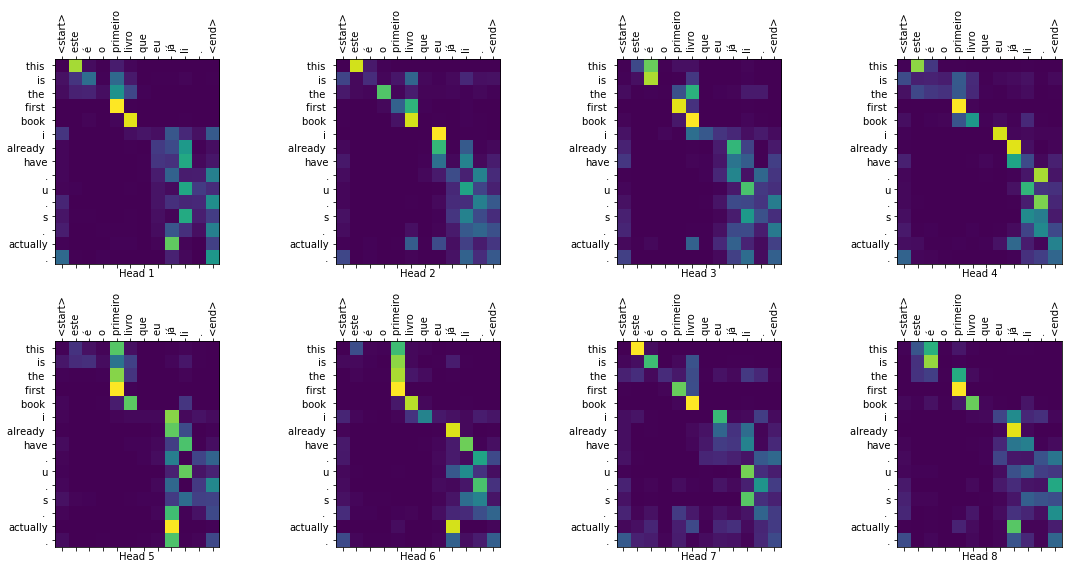

In [59]:
translate('este é o primeiro livro que eu já li.', layer_name='decoder_layer4_att2')